#Download necessary pkgs

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install scanorama

In [ ]:
!pip install leidenalg

In [ ]:
!pip install scanpy

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 831.0 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.4/124.4 kB 607.0 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 589.9 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 825.9 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.8/79.8 kB 726.9 kB/s eta 0:00:00
  Created wheel for session-info: filename=session_info-1.0.0-py3-none-any.whl size=8023 sha256=b425a1fde0afee6f327960c513fdfe8f24ec36e6a346e243d0ddfd2a1a0e06ed
  Stored in directory: /root/.cache/pip/wheels/6a/aa/b9/eb5d4031476ec10802795b97ccf937b9bd998d68a9b268765a
Successfully built session-info


In [ ]:
%%time
import h5py
# import scanorama
import scanpy as sc
import anndata as ad
import scanpy.external as sce
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.sparse import vstack, csr_matrix, csc_matrix

CPU times: user 4.15 s, sys: 617 ms, total: 4.77 s
Wall time: 7.48 s


#Get the single cell data

In [ ]:
%%time
adata = sc.read('/content/drive/MyDrive/scanorama_demo/CRCData/Patient2data.h5ad')
adata

CPU times: user 229 ms, sys: 635 ms, total: 864 ms
Wall time: 7.37 s


AnnData object with n_obs × n_vars = 32000 × 36027
    obs: 'barcodes'
    var: 'features'

In [ ]:
adata[df['Patient'] == 'P010']

View of AnnData object with n_obs × n_vars = 0 × 36027
    obs: 'barcodes'
    var: 'features'

In [ ]:
import scanpy as sc
from scipy import io

!mkdir matrix_files

with open('matrix_files/barcodes.tsv', 'w') as f:
    for item in adata1.obs['barcodes']:
        f.write(item + '\n')

with open('matrix_files/features.tsv', 'w') as f:
    for item in ['\t'.join([x,x,'Gene Expression']) for x in adata1.var['features']]:
        f.write(item + '\n')

io.mmwrite('matrix_files/matrix.mtx', adata1.X.T)

mkdir: cannot create directory ‘matrix_files’: File exists


In [ ]:
io.mmwrite('/content/drive/MyDrive/scanorama_demo/CRCData/p2data/matrix.mtx', adata1.X.T)

In [ ]:
!gzip /content/drive/MyDrive/scanorama_demo/CRCData/p2data/*

In [ ]:
adata.obs.to_csv('metadata.csv')

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/scanorama_demo/CRCData/GSE236581_CRC-ICB_metadata.txt", delimiter = " ")

In [ ]:
# Save part of the data as h5ad
adatap1 = adata[df['Patient'] == 'P09']
adatap1.obs = adatap1.obs.rename(columns = {0 : 'barcodes'})
adatap1.var = adatap1.var.rename(columns = {0 : 'features'})
adatap1.write('/content/drive/MyDrive/scanorama_demo/CRCData/p2wavelet.h5ad')

In [ ]:
!gzip /content/drive/MyDrive/scanorama_demo/CRCData/patientdata/*

In [ ]:
adata1.write('/content/drive/MyDrive/scanorama_demo/CRCData/p2wavelet.gzip.h5ad', compression = "gzip")

New Start

In [ ]:
adata1

AnnData object with n_obs × n_vars = 27805 × 2501
    obs: 'barcodes', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'SubCellType', 'MajorCellType', 'Treatment'
    var: 'features', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'pca', 'neighbors', 'umap', 'MajorCellType_colors', 'SubCellType_colors', 'Treatment_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [ ]:
def qc(adata):
    #you could also use a whitelist of barcodes from the filtered barcodes for each sample
    sc.pp.filter_cells(adata, min_genes=200)
    sc.pp.filter_genes(adata, min_cells=3)
    adata.var['mt'] = adata.var['features'].str.startswith('MT-')
    sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
    upper_lim = np.quantile(adata.obs.n_genes_by_counts.values, .98)
    lower_lim = np.quantile(adata.obs.n_genes_by_counts.values, .02)
    adata = adata[(adata.obs.n_genes_by_counts < upper_lim) & (adata.obs.n_genes_by_counts > lower_lim)]
    adata = adata[adata.obs.pct_counts_mt < 20]
    sc.pp.normalize_total(adata, target_sum=1e4)
    sc.pp.log1p(adata)
    sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
    return adata

In [ ]:
def qc2(adata):
  adata = adata[:, adata.var.highly_variable]
  sc.pp.regress_out(adata, ['total_counts', 'pct_counts_mt'])
  sc.pp.scale(adata, max_value=10)
  return adata

In [ ]:
adata = qc(adata)
# adataraw = adata.copy()
adata = qc2(adata)
adata = sc.AnnData(
    X= adata.X.copy().T,
    obs=adata.var.copy(),  # Copy over observation metadata
    var=adata.obs.copy(),  # Copy over variable metadata
)
adata

/usr/local/lib/python3.10/dist-packages/scanpy/preprocessing/_normalization.py:207: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/usr/local/lib/python3.10/dist-packages/scanpy/preprocessing/_simple.py:657: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


AnnData object with n_obs × n_vars = 2501 × 27805
    obs: 'features', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    var: 'barcodes', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'

In [ ]:
indices_to_keep = adata.obs.index
filtered_adata = adataraw[adataraw.obs.index.isin(indices_to_keep), :]
second_indices_to_keep = adata.var.index
filtered_adata = filtered_adata[:, adataraw.var.index.isin(second_indices_to_keep)]

In [ ]:
filtered_adata.write('/content/drive/MyDrive/scanorama_demo/CRCData/filteredp1.h5ad')

In [ ]:
filtered_adata

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
data = scaler.fit_transform((filtered_adata.X).toarray())

In [ ]:
filtered_adata.X = data

In [ ]:
filtered_adata.write('/content/drive/MyDrive/scanorama_demo/CRCData/normalizedp1.h5ad')

#Create the wavelet
Create the wavelet transform (3-band, 2-regular) in sparse matrix form using csr_matrix. \\

filters: \\
filter 1: \\
    0.3384 \\
    0.5308 \\
    0.7233 \\
    0.2390 \\
    0.0465 \\
   -0.1459

filter 2: \\
   -0.1174 \\
    0.5443 \\
   -0.0187 \\
   -0.6991 \\
   -0.1361 \\
    0.4270

filter 3: \\
    0.4036 \\
   -0.6285 \\
    0.4606 \\
   -0.4036 \\
   -0.0786 \\
    0.2465

In [ ]:
%%time
df = pd.read_csv('/content/drive/MyDrive/scanorama_demo/small_dataset/filters3.txt')

def createWavelet(band, L, length):
    rows = []
    columns = []
    data = []
    for i in range(band):
        for j in range(int(length/band)):
            start = j*band
            row = i*(int(length/band)) + j
            columns_row = [m%length for m in range(start, start + band*L)]
            rows_row = [row for m in range(start, start + band*L)]
            data_row = list(df["f" + str(i+1)])
            for k in rows_row:
              rows.append(k)
            for k in columns_row:
              columns.append(k)
            for k in data_row:
              data.append(k)
    return csr_matrix((data, (rows, columns)), shape=(length, length))

def createReturnWavelet(band, L, filter, length):
    rows = []
    columns = []
    data = []
    for j in range(int(length / band)):
        start = j * band
        rows_row = [m % length for m in range(start, start + band * L)]
        columns_row = [j for m in range(start, start + band * L)]
        data_row = list(df["f" + str(filter)])
        for k in rows_row:
            rows.append(k)
        for k in columns_row:
            columns.append(k)
        for k in data_row:
            data.append(k)
    return csr_matrix((data, (rows, columns)), shape=(length, int(length / band)))

#change for filter
wavelet_trans = createWavelet(4, 2, 2504)
wavelet_trans

CPU times: user 41.5 ms, sys: 2.22 ms, total: 43.7 ms
Wall time: 1.01 s


<2504x2504 sparse matrix of type '<class 'numpy.float64'>'
	with 20032 stored elements in Compressed Sparse Row format>

#Expand data
Add zero row to the adata matrix (in a new variable data) to make it fit the wavelet transform

In [ ]:
adata.X

<51134x2443 sparse matrix of type '<class 'numpy.float32'>'
	with 6610659 stored elements in Compressed Sparse Column format>

In [ ]:
row_of_zeros = np.zeros((3, adata.X.shape[1]))
data = np.vstack([adata.X, row_of_zeros])
data

array([[-0.07679224, -0.1452243 , -0.08677902, ..., -0.09015394,
        -0.11155949, -0.10165981],
       [-0.1966779 ,  5.04289725,  5.0539518 , ..., -0.07322301,
        -0.18421141, -0.1885161 ],
       [-0.58954797, -0.32355133, -0.56434421, ..., -0.55203511,
        -0.46779032, -0.50240073],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

#Apply wavelet to data (just by multiplying?)
Multiply the wavelet transform with the new data matrix.
The new data is the wavelet coefficients. In order to return it to its original domain, multiply by the createReturnWavelet that creates a transpose of the low pass filter.
Now, duplicate adata with the new wavelet coefficients.

In [ ]:
2504/2

1252.0

In [ ]:
%%time
wavelet_size = 2504
initial_size = 2501
result = wavelet_trans@(data)
result1 = ((wavelet_trans.T)[:, :int(wavelet_size/4)])@(result[:int(wavelet_size/4)])
result2 = ((wavelet_trans.T)[:, int(wavelet_size/4):int(wavelet_size/2)])@(result[int(wavelet_size/4):int(wavelet_size/2)])
result3 = ((wavelet_trans.T)[:, int(wavelet_size/2):int(wavelet_size*3/4)])@(result[int(wavelet_size/2):int(wavelet_size*3/4)])
result4 = ((wavelet_trans.T)[:, int(wavelet_size*3/4):])@(result[int(wavelet_size*3/4):])
adata1 = sc.AnnData(
    X=result1[:initial_size].T,
    var=adata.obs.copy(),  # Copy over observation metadata
    obs=adata.var.copy(),  # Copy over variable metadata
)
adata2 = sc.AnnData(
    X=result2[:initial_size].T,
    var=adata.obs.copy(),  # Copy over observation metadata
    obs=adata.var.copy(),  # Copy over variable metadata
)
adata3 = sc.AnnData(
    X=result3[:initial_size].T,
    var=adata.obs.copy(),  # Copy over observation metadata
    obs=adata.var.copy(),  # Copy over variable metadata
)
adata4 = sc.AnnData(
    X=result4[:initial_size].T,
    var=adata.obs.copy(),  # Copy over observation metadata
    obs=adata.var.copy(),  # Copy over variable metadata
)

# Optionally, update the original AnnData object with the result
# adata = adata_result  # Uncomment if you want to replace adata with adata_result

# Print shapes for verification
print("adata.X shape:", adata.X.shape)
adata1

adata.X shape: (2501, 27805)
CPU times: user 1.34 s, sys: 2.86 s, total: 4.19 s
Wall time: 4.11 s


AnnData object with n_obs × n_vars = 27805 × 2501
    obs: 'barcodes', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'features', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'

#Do dimensionality reduction

In [ ]:
# sc.tl.pca(adata)
# sc.pp.neighbors(adata)
# # sc.tl.tsne(adata)
# sc.tl.umap(adata)

In [ ]:
%%time
sc.tl.pca(adata1)
sc.pp.neighbors(adata1)
# sc.tl.tsne(adata)
sc.tl.umap(adata1)

sc.tl.pca(adata2)
sc.pp.neighbors(adata2)
# sc.tl.tsne(adata)
sc.tl.umap(adata2)

sc.tl.pca(adata3)
sc.pp.neighbors(adata3)
# sc.tl.tsne(adata)
sc.tl.umap(adata3)

sc.tl.pca(adata4)
sc.pp.neighbors(adata4)
# sc.tl.tsne(adata)
sc.tl.umap(adata4)
adata


CPU times: user 7min, sys: 28.1 s, total: 7min 28s
Wall time: 3min 27s


AnnData object with n_obs × n_vars = 2501 × 27805
    obs: 'features', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    var: 'barcodes', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'

In [ ]:
# sc.tl.leiden(adata1, resolution = 0.25)

In [ ]:
# adata2.obs['leiden'] = adata1.obs['leiden'].copy()
# adata3.obs['leiden'] = adata1.obs['leiden'].copy()
# adata4.obs['leiden'] = adata1.obs['leiden'].copy()

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/scanorama_demo/CRCData/GSE236581_CRC-ICB_metadata.txt", delimiter = " ")

In [ ]:
adata1

AnnData object with n_obs × n_vars = 51134 × 2443
    obs: 'barcodes', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden'
    var: 'features', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'pca', 'neighbors', 'umap', 'leiden'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [ ]:
#change
positions = adata1.obs.index
boolList = [str(i) in positions for i in range(975275)]
boolList.count(True)

27805

In [ ]:
adata1

AnnData object with n_obs × n_vars = 27805 × 2501
    obs: 'barcodes', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'features', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'pca', 'neighbors', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [ ]:
# adata.obs = adata.obs.assign(SubCellType = list(df[boolList]['SubCellType']))
# adata.obs = adata.obs.assign(MajorCellType = list(df[boolList]['MajorCellType']))
# adata.obs = adata.obs.assign(Treatment = list(df[boolList]['Treatment']))

In [ ]:
list(df[boolList]['SubCellType'])

2501

In [ ]:
adata1.obs = adata1.obs.assign(SubCellType = list(df[boolList]['SubCellType']))

In [ ]:
adata2.obs['SubCellType'] = adata1.obs['SubCellType'].copy()
adata3.obs['SubCellType'] = adata1.obs['SubCellType'].copy()
adata4.obs['SubCellType'] = adata1.obs['SubCellType'].copy()

In [ ]:
adata1.obs = adata1.obs.assign(MajorCellType = list(df[boolList]['MajorCellType']))

In [ ]:
adata2.obs['MajorCellType'] = adata1.obs['MajorCellType'].copy()
adata3.obs['MajorCellType'] = adata1.obs['MajorCellType'].copy()
adata4.obs['MajorCellType'] = adata1.obs['MajorCellType'].copy()

In [ ]:
adata1.obs = adata1.obs.assign(Treatment = list(df[boolList]['Treatment']))

In [ ]:
adata2.obs['Treatment'] = adata1.obs['Treatment'].copy()
adata3.obs['Treatment'] = adata1.obs['Treatment'].copy()
adata4.obs['Treatment'] = adata1.obs['Treatment'].copy()

In [ ]:
# adata1 = adata

In [ ]:
# adata.write('/content/drive/MyDrive/scanorama_demo/CRCData/fullp1.h5ad')

<Axes: title={'center': 'Detail 3'}, xlabel='UMAP1', ylabel='UMAP2'>

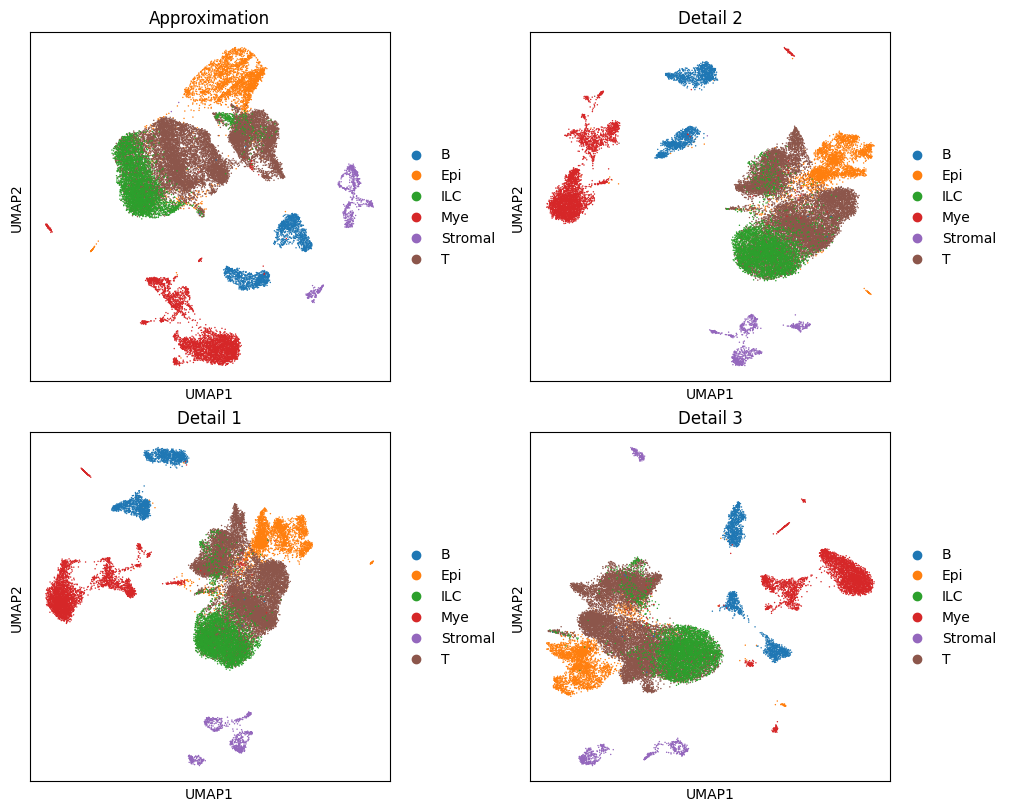

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(10,8),constrained_layout=True)
sc.pl.embedding(adata1, basis='umap', color='MajorCellType', title='Approximation', ax=axs[0,0], show=False)
sc.pl.embedding(adata2, basis='umap', color='MajorCellType', title='Detail 1', ax=axs[1,0], show=False)
sc.pl.embedding(adata3, basis='umap', color='MajorCellType', title='Detail 2', ax=axs[0,1], show=False)
sc.pl.embedding(adata4, basis='umap', color='MajorCellType', title='Detail 3', ax=axs[1,1], show=False)

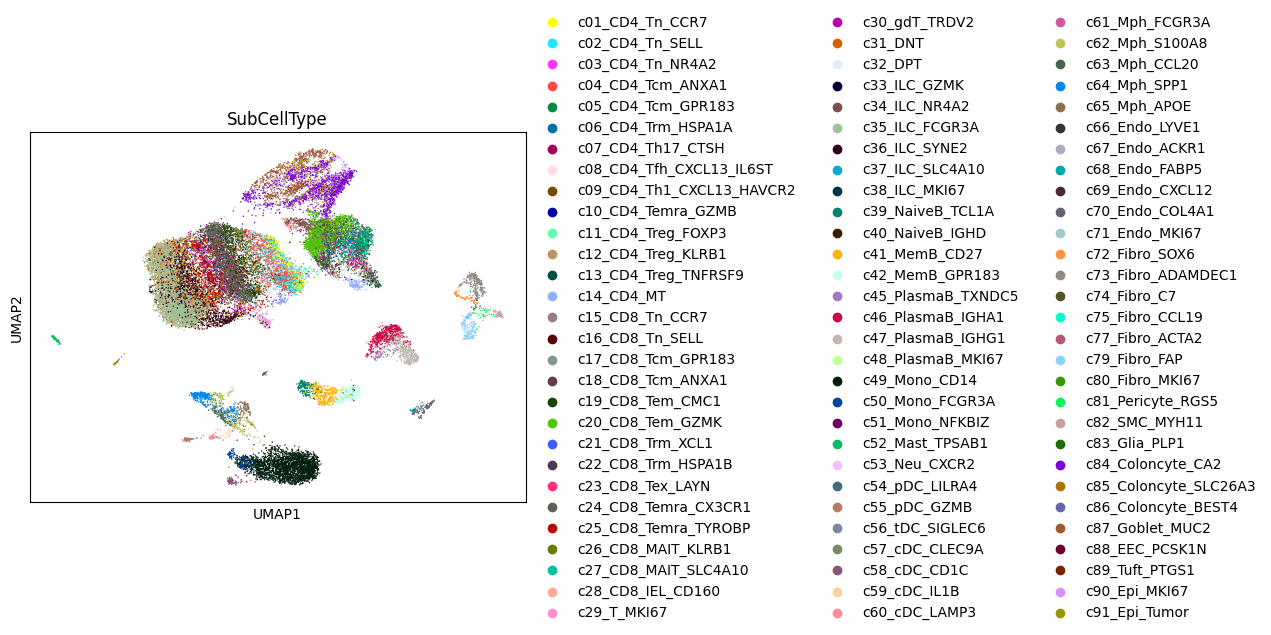

In [ ]:
sc.pl.umap(adata1, color=['SubCellType'])

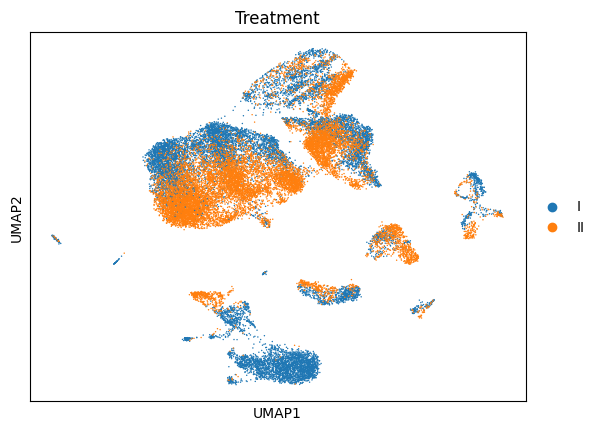

In [ ]:
sc.pl.umap(adata1, color=['Treatment'])

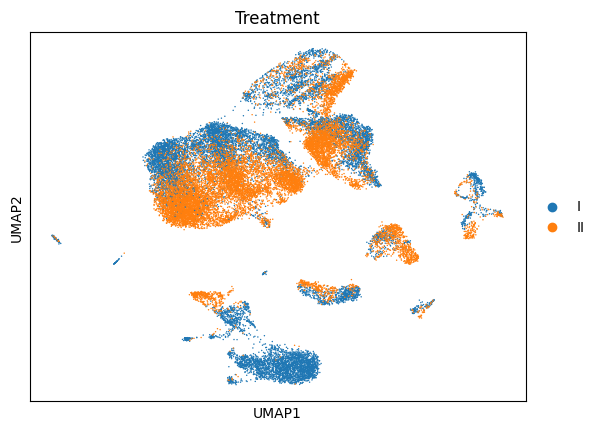

In [ ]:
sc.pl.umap(adata1, color=['Treatment'])

In [ ]:
sc.tl.diffmap(adata1)

In [ ]:
sc.pp.neighbors(adata1, n_neighbors=10, use_rep="X_diffmap")

In [ ]:
df[np.array(df['Patient'] == 'P01') & np.array(df['Treatment'] == 'I')]['SubCellType'].value_counts()

SubCellType
c25_CD8_Temra_TYROBP    1453
c24_CD8_Temra_CX3CR1    1422
c35_ILC_FCGR3A           963
c49_Mono_CD14            935
c22_CD8_Trm_HSPA1B       528
                        ... 
c75_Fibro_CCL19            1
c79_Fibro_FAP              1
c70_Endo_COL4A1            1
c80_Fibro_MKI67            1
c44_GCB_MKI67              1
Name: count, Length: 83, dtype: int64

In [ ]:
adata1.uns['iroot'] = np.flatnonzero(adata1.obs['SubCellType']  == 'c24_CD8_Temra_CX3CR1')[0]

In [ ]:
adata1

AnnData object with n_obs × n_vars = 57220 × 2344
    obs: 'barcodes', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden', 'SubCellType', 'MajorCellType'
    var: 'features', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'leiden', 'neighbors', 'pca', 'umap', 'diffmap_evals', 'iroot'
    obsm: 'X_pca', 'X_umap', 'X_diffmap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

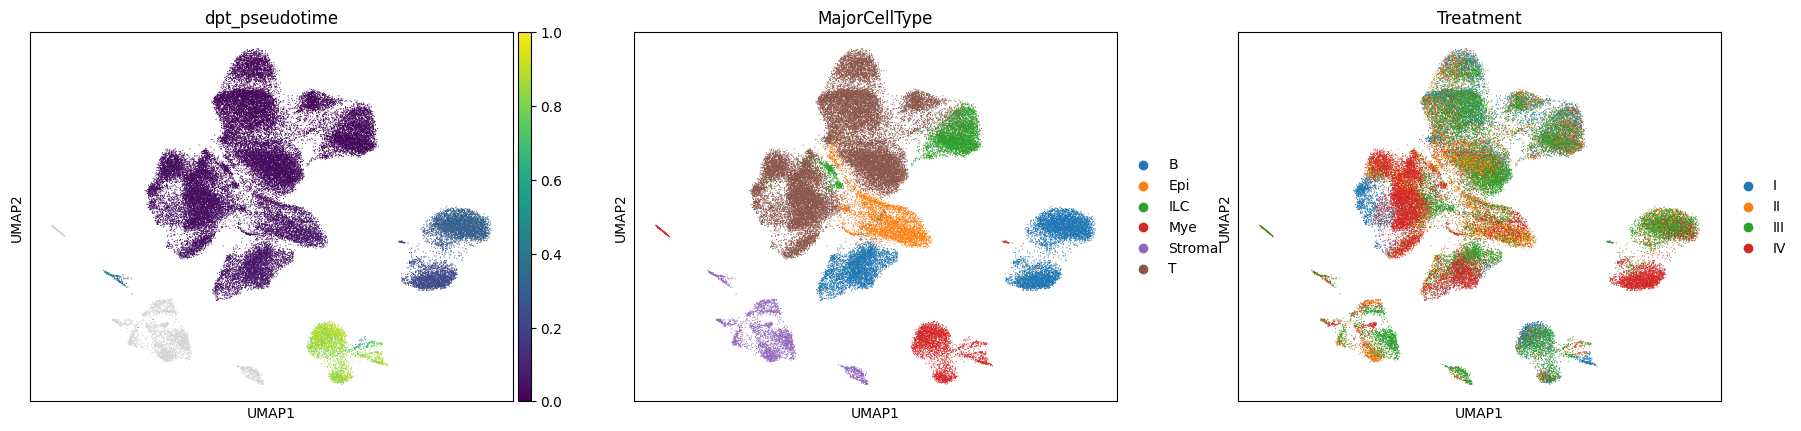

In [ ]:
sc.tl.dpt(adata1, n_branchings=1, n_dcs=10)
sc.pl.umap(adata1, color=['dpt_pseudotime', 'MajorCellType', 'Treatment'])

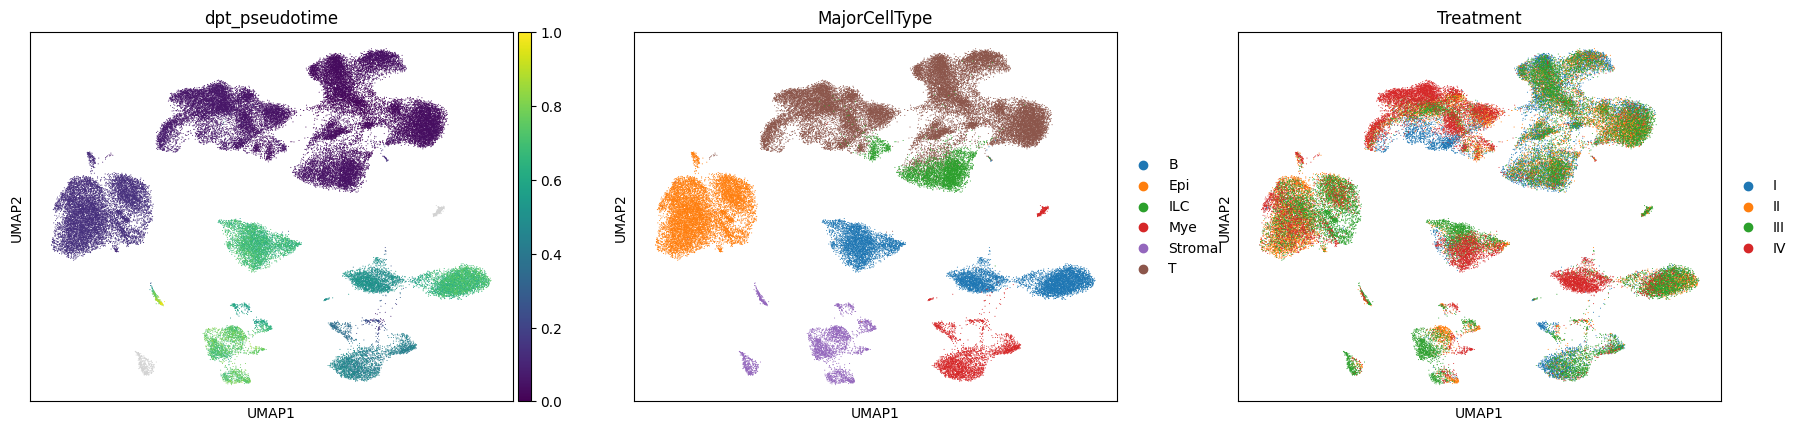

In [ ]:
sc.tl.dpt(adata1, n_branchings=1, n_dcs=10)
sc.pl.umap(adata1, color=['dpt_pseudotime', 'MajorCellType', 'Treatment'])

In [ ]:
adata1.write('/content/drive/MyDrive/scanorama_demo/CRCData/p1wavelet2.h5ad')

In [ ]:
# adataraw.obs['leiden'] = adata1.obs['leiden'].copy()
# adataraw.obs['SubCellType'] = adata1.obs['SubCellType'].copy()

In [ ]:
adata1

AnnData object with n_obs × n_vars = 57220 × 2344
    obs: 'barcodes', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden', 'SubCellType', 'MajorCellType', 'Treatment', 'dpt_pseudotime', 'dpt_groups', 'dpt_order', 'dpt_order_indices'
    var: 'features', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'leiden', 'neighbors', 'pca', 'umap', 'diffmap_evals', 'iroot', 'dpt_changepoints', 'dpt_grouptips', 'MajorCellType_colors', 'Treatment_colors'
    obsm: 'X_pca', 'X_umap', 'X_diffmap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [ ]:
adata1.obs['dpt_pseudotime'] = [round(num, 1) for num in adata1.obs['dpt_pseudotime']]

In [ ]:
adata1.obs['dpt_pseudotime']

0         0.13
1         0.14
3         0.13
5         0.15
6         0.13
          ... 
970304    0.03
970305    0.04
970306    0.04
970307    0.03
970308    0.03
Name: dpt_pseudotime, Length: 57220, dtype: float64

In [ ]:
np.arange(0, 1.1, 0.1)

array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])

In [ ]:
table = pd.DataFrame()
pseudotimes = adata1.obs['dpt_pseudotime']
for i in np.arange(0, 1.1, 0.1):
  table[i] = adata1.obs[np.array(pseudotimes == i)]['MajorCellType'].value_counts()
table


,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0
MajorCellType,,,,,,,,,,,
T,18383,8388,6,0,4,0,0,0,0,0,0
ILC,3884,182,0,0,0,0,0,0,0,0,0
Mye,1,14,26,0,323,1666,0,0,0,0,0
B,0,8,6,0,2462,3981,0,0,0,0,0
Epi,0,54,10342,0,1,0,0,0,0,0,0
Stromal,0,2,4,0,4,10,0,0,1301,684,25


In [ ]:
table.iloc[:, 20:40]

,0.20,0.21,0.22,0.23,0.24,0.25,0.26,0.27,0.28,0.29,0.30,0.31,0.32,0.33,0.34,0.35,0.36,0.37,0.38,0.39
MajorCellType,,,,,,,,,,,,,,,,,,,,
T,0,1,0,0,0,1,0,1,1,0,1,1,0,0,2,0,0,0,1,0
ILC,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
B,0,1,2,0,0,0,0,1,2,0,0,0,0,0,1,0,4,6,9,13
Epi,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Mye,11,14,21,20,8,9,7,9,5,9,14,18,33,66,65,0,117,122,137,156
Stromal,0,0,0,1,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0


In [ ]:
table = table.iloc[:, 0:20]

In [ ]:
table.iloc[3, 0] = 1

In [ ]:
table

,0.00,0.01,0.02,0.03,0.04,0.05,0.06,0.07,0.08,0.09,0.10,0.11,0.12,0.13,0.14,0.15,0.16,0.17,0.18,0.19
MajorCellType,,,,,,,,,,,,,,,,,,,,
T,90,1060,3830,7838,3873,3557,5437,806,238,11,5,7,10,6,3,0,0,2,0,0
ILC,1,32,88,387,2157,1246,147,3,0,0,0,1,3,0,0,0,0,0,0,0
B,0,0,0,0,0,0,1,0,0,0,0,0,0,0,2,2,1,1,1,0
Epi,1,0,0,0,0,0,2,0,0,1,2,21,722,4936,4528,183,1,0,1,1
Mye,0,0,0,0,0,0,0,0,6,1,6,2,2,2,2,5,3,7,1,2
Stromal,0,0,0,0,0,0,1,0,0,0,0,0,1,1,2,0,0,0,0,0


In [ ]:
!pip install lmfit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.9/98.9 kB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 14.0 MB/s eta 0:00:00


In [ ]:
cell_data = pd.read_csv('/content/drive/MyDrive/scanorama_demo/CRCData/p2subcell_counts1.csv')

In [ ]:
data = pd.DataFrame()
for i in cell_data['Var2'].unique():
  data[i] = np.array(cell_data[cell_data['Var2'] == i]['Freq'])

In [ ]:
data

,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,...,15.0,16.0,17.0,18.0,19.0,20.0,21.0,22.0,23.0,sum
c01_CD4_Tn_CCR7,0,64,63,41,29,59,99,17,0,0,...,0,0,0,0,0,0,0,0,0,372
c02_CD4_Tn_SELL,0,61,46,34,38,152,138,8,0,0,...,0,0,0,0,0,0,0,0,0,477
c03_CD4_Tn_NR4A2,0,0,0,0,1,3,3,2,2,0,...,16,104,0,0,0,0,0,0,0,131
c04_CD4_Tcm_ANXA1,2,93,70,62,42,186,72,16,1,0,...,2,6,0,0,0,0,0,0,0,552
c05_CD4_Tcm_GPR183,0,3,0,2,0,3,1,1,2,2,...,67,378,0,0,0,0,0,0,0,472
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
c87_Goblet_MUC2,0,14,5,2,2,1,5,2,0,0,...,9,4,51,217,12,38,60,201,75,713
c88_EEC_PCSK1N,0,3,1,2,0,0,1,0,0,3,...,0,2,2,1,0,0,1,1,0,17
c89_Tuft_PTGS1,0,7,0,0,1,1,3,0,0,1,...,0,1,2,2,0,0,0,1,1,23
c90_Epi_MKI67,0,26,3,3,3,2,11,25,2,6,...,16,41,100,33,18,37,5,19,33,401


In [ ]:
data = data.rename(index = (dict(zip(np.array(range(data.shape[0])), np.array(cell_data['Var1'].unique())))))
data = data.drop(columns = [float('inf')])

In [ ]:
data['sum'] = data.sum(axis=1)

In [ ]:
data[data.index.str.contains('CD8')]

,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,...,14.0,15.0,16.0,17.0,18.0,19.0,20.0,21.0,22.0,23.0
c15_CD8_Tn_CCR7,0,35,22,14,9,66,13,3,0,0,...,0,0,0,0,0,0,0,0,0,0
c16_CD8_Tn_SELL,0,0,0,0,0,0,0,0,0,0,...,1,3,2,0,0,0,0,0,0,0
c17_CD8_Tcm_GPR183,0,117,72,74,7,73,10,6,0,0,...,1,0,0,0,0,0,0,0,0,0
c18_CD8_Tcm_ANXA1,0,0,0,1,0,0,0,0,2,3,...,58,23,25,0,0,0,0,0,0,0
c19_CD8_Tem_CMC1,0,156,116,195,77,52,48,87,0,0,...,2,0,0,0,0,0,0,0,0,0
c20_CD8_Tem_GZMK,0,0,5,9,1,3,3,6,50,196,...,329,42,28,0,0,0,0,0,0,0
c21_CD8_Trm_XCL1,0,1,0,0,1,0,0,0,6,46,...,51,4,16,0,0,0,0,0,0,0
c22_CD8_Trm_HSPA1B,0,0,2,2,2,3,1,13,170,97,...,62,9,20,0,0,0,0,0,0,0
c23_CD8_Tex_LAYN,0,1,0,1,0,0,0,1,14,13,...,2,0,9,0,0,0,0,0,0,0
c24_CD8_Temra_CX3CR1,3,272,368,384,326,570,280,39,0,7,...,5,0,0,0,0,0,0,0,0,0


In [ ]:
data = data.iloc[[2, 1, 0]].T

In [ ]:
data = data.astype(float)

In [ ]:
data = data[data.sum(axis=1) >= 30]

In [ ]:
data[data.index.str.contains('Coloncyte')]

,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,...,14.0,15.0,16.0,17.0,18.0,19.0,20.0,21.0,22.0,23.0
c84_Coloncyte_CA2,0,132,13,14,4,17,36,13,5,17,...,45,102,224,374,183,26,11,0,45,151
c85_Coloncyte_SLC26A3,0,0,0,0,0,0,0,1,0,0,...,0,0,1,1,15,0,0,0,8,0
c86_Coloncyte_BEST4,0,11,2,1,0,1,7,1,0,2,...,4,4,8,14,21,0,0,0,0,0


In [ ]:
cd4_rows = data[data.index.str.contains('CD4')]
cd8_rows = data[data.index.str.contains('CD8')]


cd_sum = pd.DataFrame({'CD4' : cd4_rows.sum(),
                       'CD8' : cd8_rows.sum(),
                       'c91' : data.loc['c91_Epi_Tumor']})

cd_sum

In [ ]:
cd4_rows = data[data.index.str.contains('CD4')]
cd8_rows = data[data.index.str.contains('CD8')]
coloncyte_rows = data[data.index.str.contains('Coloncyte')]

#/(data[data.index.str.contains('CD8')]).shape[0]
cd_sum = pd.DataFrame({'CD4' : cd4_rows.sum(),
                       'CD8' : cd8_rows.sum(),
                       'Coloncyte' : coloncyte_rows.sum()})

cd_sum

,CD4,CD8,Coloncyte
0.0,2,3,0
1.0,249,748,143
2.0,242,749,15
3.0,202,890,15
4.0,146,495,4
5.0,543,1091,18
6.0,377,550,43
7.0,113,223,15
8.0,107,253,5
9.0,23,409,19


In [ ]:
data.iloc[5, 1] = 14

In [ ]:
cd_sum = np.log1p(cd_sum)

In [ ]:
data = cd_sum

In [ ]:
data = data.iloc[:-8]

In [ ]:
data['year'] = np.linspace(0, 5, 16)

<ipython-input-32-f6cf8eca8026>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['year'] = np.linspace(0, 5, 16)


In [ ]:
data

,CD4,CD8,c91,year
0.0,0.133531,0.194156,0.693147,0.000000
1.0,2.933097,3.996889,2.944439,0.333333
2.0,2.906120,3.998201,2.302585,0.666667
3.0,2.736221,4.167772,1.609438,1.000000
4.0,2.436116,3.593391,0.000000,1.333333
5.0,3.683508,4.368543,2.708050,1.666667
6.0,3.329650,3.695997,2.197225,2.000000
7.0,2.205130,2.829003,2.484907,2.333333
8.0,2.156733,2.948191,1.386294,2.666667
9.0,0.971861,3.408315,1.609438,3.000000


In [ ]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import pytensor
import pytensor.tensor as pt

from numba import njit
from pymc.ode import DifferentialEquation
from pytensor.compile.ops import as_op
from scipy.integrate import odeint
from scipy.optimize import least_squares

#change
species = 3
az.style.use("arviz-darkgrid")
rng = np.random.default_rng(1234)
time = np.arange(0, 5, 0.01)
color = dict(zip(range(species), plt.cm.tab20(range(species))))


def plot_data(ax, fig, lw=2, title="Population by Cell Type"):
    for i in range(species):
      ax.plot(data.year, data.iloc[:, i], color=color[i], lw=lw, marker="o", markersize=12, label=data.columns[i])
    ax.legend(fontsize=14, loc="center left", bbox_to_anchor=(0.6, 0.5))
    ax.set_xlim([0, 10])
    ax.set_ylim(0)
    ax.set_xlabel("Pseudotime", fontsize=14)
    ax.xaxis.set_label_coords(0.3, -0.1)
    ax.set_ylabel("Cell Type Populations", fontsize=14)
    ax.set_xticks(data.year.astype(int))
    ax.set_xticklabels(ax.get_xticks(), rotation=45)
    fig.text(0.3, 1, title, ha='center', fontsize=16, color='black', fontweight='bold')
    return ax

_, ax = plt.subplots(figsize=(12, 4))
plot_data(ax, _);

@njit
def lotka_volterra_multi(X, t, theta):
    #change
    species = 3
    dXdt = np.zeros(species)
    r = theta[:species]
    alpha = theta[species:(species + species * species)]
    K = theta[(species + species * species):(2 * species + species * species)]
    for i in range(species):
        interaction_sum = 0.0
        for j in range(species):
            interaction_sum += alpha[i * species + j] * X[j]
        growth = r[i] * X[i] * (1 - (interaction_sum / K[i]))
        dXdt[i] = growth
    return list(dXdt)

def plot_model(ax, fig, x_y, time=time, alpha=1, lw=3, title="Lotka-Volterra Model",):
    for i in range(species):
      ax.plot(data.year, data.iloc[:, i], color=color[i], lw=0, marker="o", markersize=12, label=data.columns[i])
    ax.legend(fontsize=14, loc="center left", bbox_to_anchor=(0.6, 0.5))
    ax.set_xlim([0, 10])
    ax.set_ylim(0)
    ax.set_xlabel("Pseudotime", fontsize=14)
    ax.xaxis.set_label_coords(0.3, -0.1)
    ax.set_ylabel("Cell Type Populations", fontsize=14)
    ax.set_xticks(data.year.astype(int))
    ax.set_xticklabels(ax.get_xticks(), rotation=45)
    for i in range(species):
      ax.plot(time, x_y[:, i], color=color[i], alpha=alpha, lw=lw, label=data.columns[i])
    ax.legend(fontsize=14, loc="center left", bbox_to_anchor=(0.6, 0.5))
    fig.text(0.3, 1, title, ha='center', fontsize=16, color='black', fontweight='bold')
    return ax

#change
X = [7, 2, 1]
r = [0.2, 0.3, 0.5]
alpha = [[1, 0.1, 0.1],
         [0.1, 1, 0.1],
         [0.1, 0.1, 1]]
alpha = [item for sublist in alpha for item in sublist]
K = [2000, 2000, 2000]

# X = [3, 3, 3, 3]
# r = [0.2, 0.3, 0.3, 0.2]
# alpha = [[1, 0.01, 0.01, 0.01],
#          [0.01, 1, 0.01, 0.01],
#          [0.01, 0.01, 1, 0.01],
#          [0.01, 0.01, 0.01, 1]]
# alpha = [item for sublist in alpha for item in sublist]
# K = [300, 300, 300, 300]

# X = [3, 3, 3, 3, 3]
# r = [0.2, 0.3, 0.3, 0.2, 0.2]
# alpha = [[1, 0.01, 0.01, 0.01, 0.01],
#          [0.01, 1, 0.01, 0.01, 0.01],
#          [0.01, 0.01, 1, 0.01, 0.01],
#          [0.01, 0.01, 0.01, 1, 0.01],
#          [0.01, 0.01, 0.01, 0.01, 1]]
# alpha = [item for sublist in alpha for item in sublist]
# K = [300, 300, 300, 300, 300]

theta = r + alpha + K + X

def ode_model_resid(theta):
    return (
        data.iloc[:, :-1] - odeint(func=lotka_volterra_multi, y0=theta[-species:], t=data.year, args=(theta,))
    ).values.flatten()

lower_bound = [0] * len(theta)
lower_bound[species], lower_bound[2*species + 1], lower_bound[3*species + 2] = 0.999999, 0.999999, 0.999999
upper_bound = [np.inf] * len(theta)
upper_bound[species], upper_bound[2*species + 1], upper_bound[3*species + 2] = 1.000001, 1.000001, 1.000001

results = least_squares(ode_model_resid, x0=theta, bounds = (lower_bound, upper_bound))

theta = results.x
print(theta)
x_y = odeint(func=lotka_volterra_multi, y0=theta[-species:], t=time, args=(theta,))
fig, ax = plt.subplots(figsize=(12, 4))
plot_model(ax, fig, x_y, title="LV Model Fit");

# @as_op(itypes=[pt.dvector], otypes=[pt.dmatrix])
# def pytensor_forward_model_matrix(theta):
#     return odeint(func=lotka_volterra_multi, y0=theta[-species:], t=data.year, args=(theta,))

# theta = results.x
# with pm.Model() as model:
#     r = theta[:species]
#     alpha = theta[species:(species + pow(species, 2))]
#     K = theta[(species + pow(species, 2)):(2 * species + pow(species, 2))]
#     X = theta[-species:]
#     X_prior = []
#     r_prior = []
#     K_prior = []
#     for i in range(species):
#         r_prior.append(pm.TruncatedNormal("r_" + str(i), mu=r[i], lower = r[i] - 0.001, upper = r[i] + 0.001, sigma=0.001, initval=r[i]))
#         K_prior.append(pm.TruncatedNormal("K_" + str(i), mu=K[i], lower = K[i] - 0.001, upper = K[i] + 0.001, sigma=0.001, initval=K[i]))
#         X_prior.append(pm.TruncatedNormal("X_" + str(i), mu=X[i], lower = X[i] - 0.001, upper = X[i] + 0.001, sigma=0.001, initval=X[i]))


#     alpha_prior = []
#     for i in range(species):
#         alpha_prior.append([])
#         for j in range(species):
#             if i == j:
#                 alpha_prior[i].append(pm.TruncatedNormal("alpha_" + str(i) + "_" + str(j), mu=alpha[i * species + j], lower=alpha[i * species + j] - 0.001, upper = alpha[i * species + j] + 0.001, sigma=0.001,
#                                                      initval=alpha[i * species + j]))
#             else:
#                 alpha_prior[i].append(pm.TruncatedNormal("alpha_" + str(i) + "_" + str(j), mu=alpha[i * species + j], lower=alpha[i * species + j] - 0.001, upper = alpha[i * species + j] + 0.001, sigma=0.001,
#                                                      initval=alpha[i * species + j]))
#     sigma = pm.HalfNormal("sigma", 10)

#     flattened_alpha_prior = [item for sublist in alpha_prior for item in sublist]
#     all_priors = r_prior + flattened_alpha_prior + K_prior + X_prior

#     ode_solution = pytensor_forward_model_matrix(
#         pm.math.stack(all_priors)
#     )

#     pm.Normal("Y_obs", mu=ode_solution, sigma=sigma, observed=data.iloc[:, :-1].values)

# vars_list = list(model.values_to_rvs.keys())[:-1]

# sampler = "Slice Sampler"
# tune = draws = 200

# with model:
#     trace_slice = pm.sample(step=[pm.Slice(vars_list)], tune=tune, draws=draws)
# trace = trace_slice
# az.summary(trace)

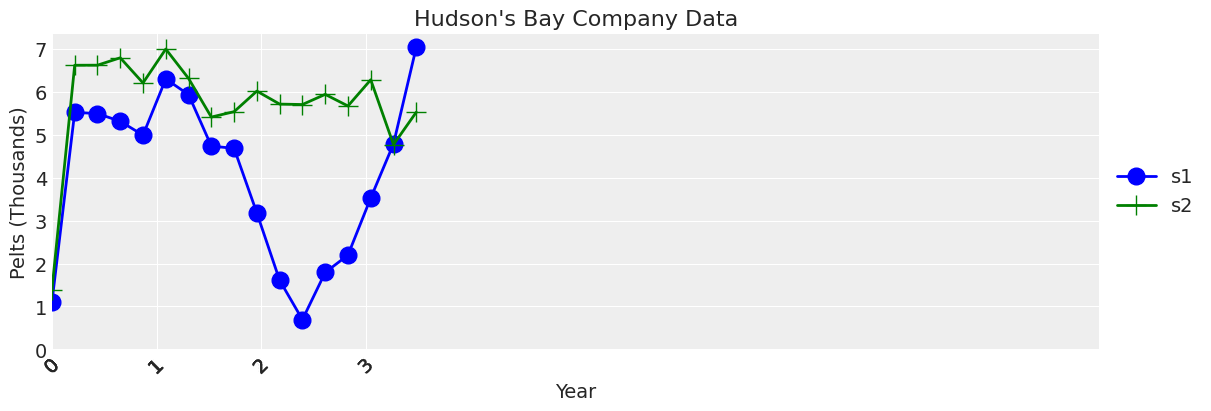

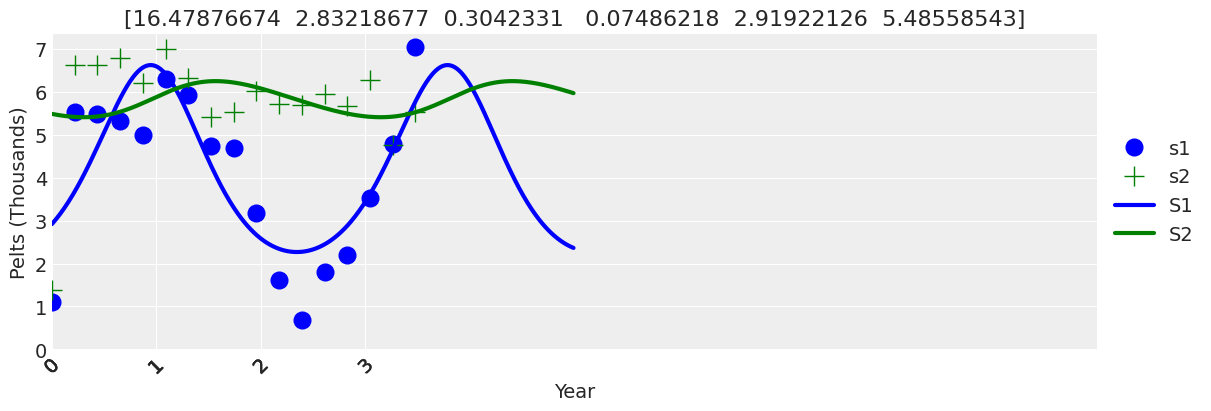

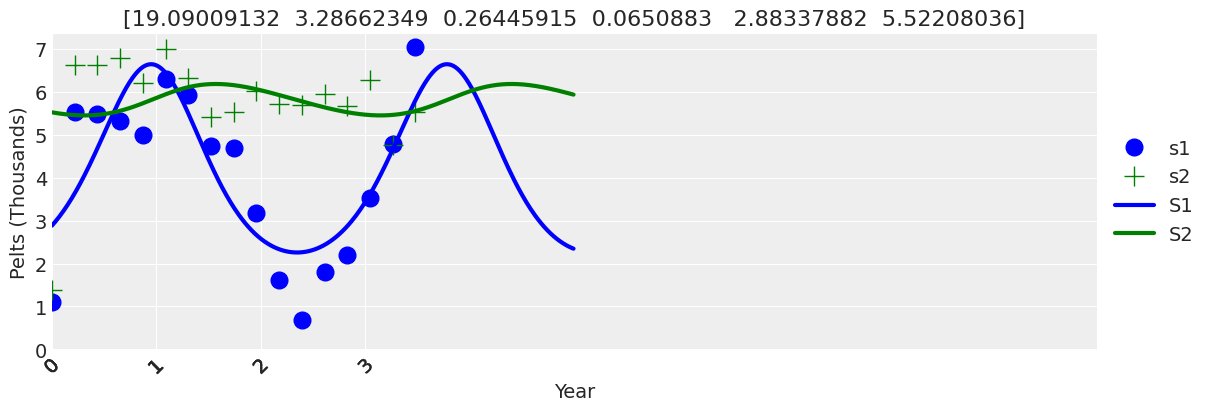

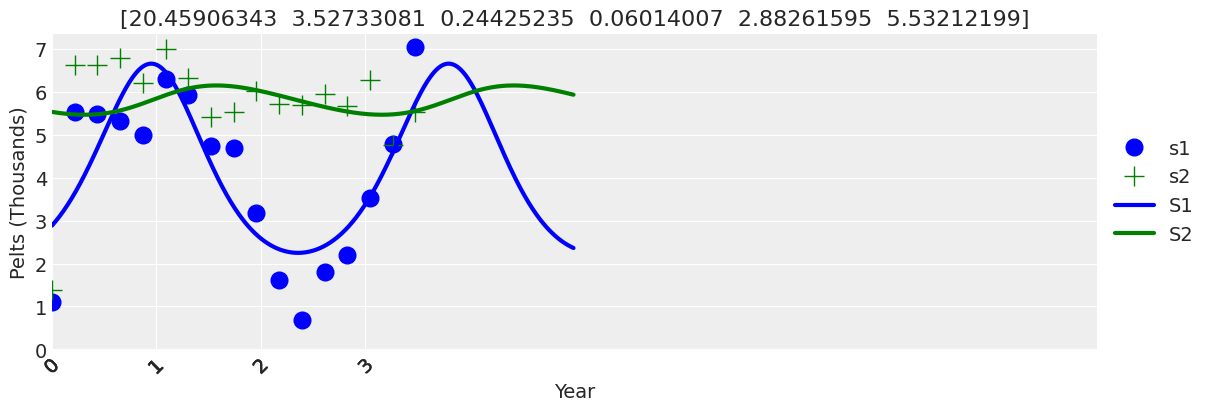

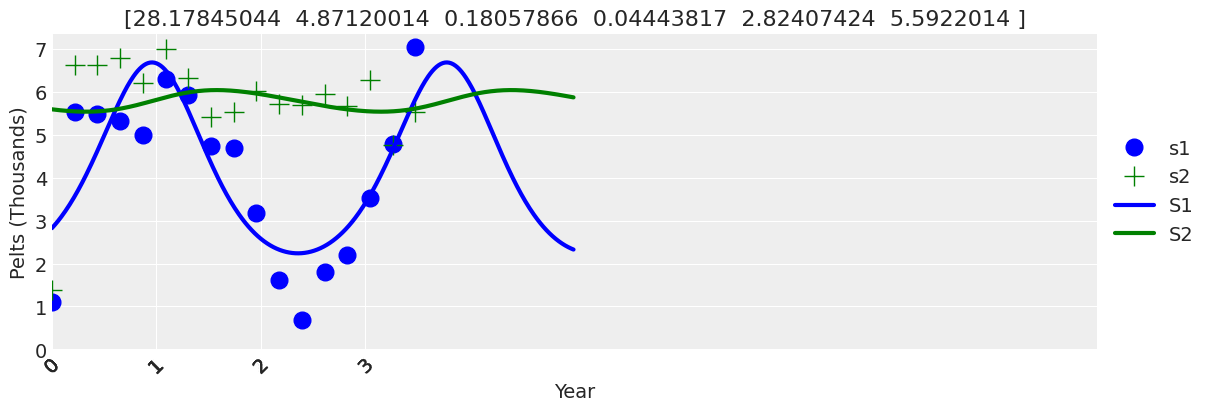

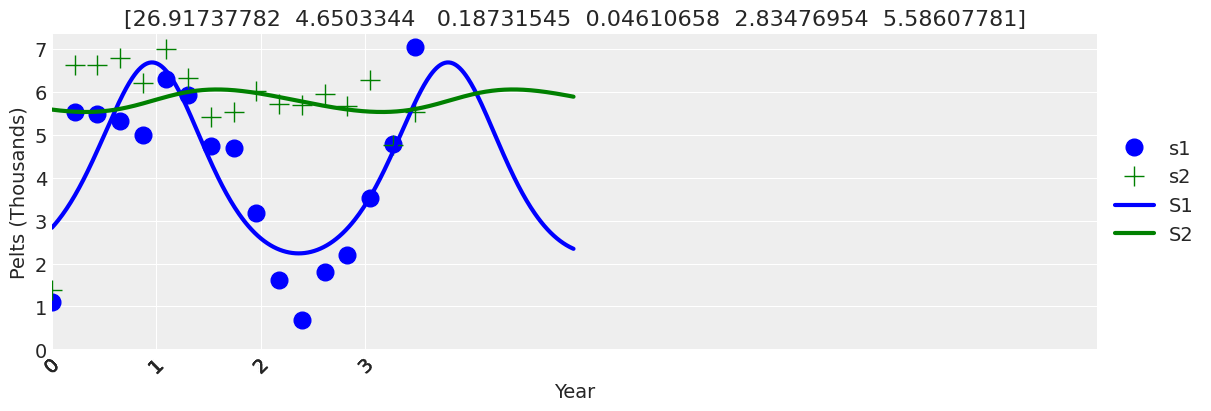

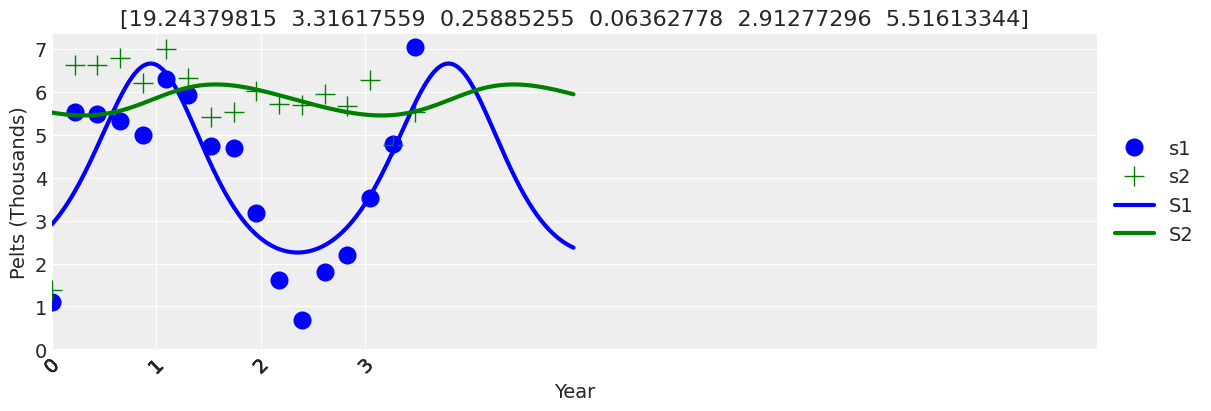

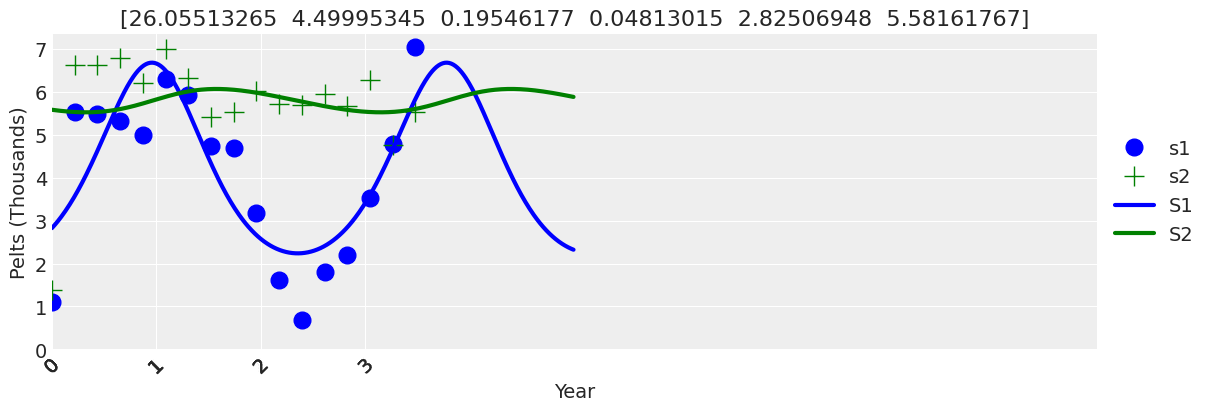

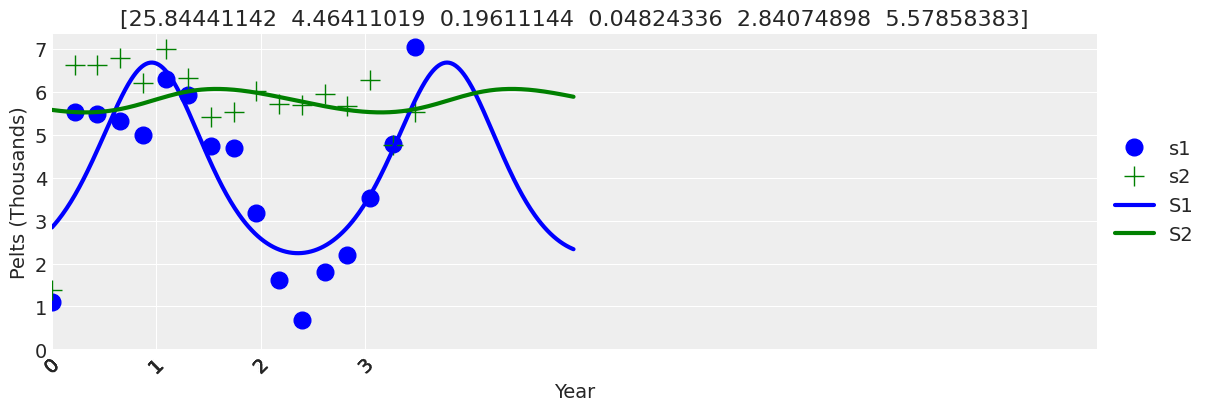

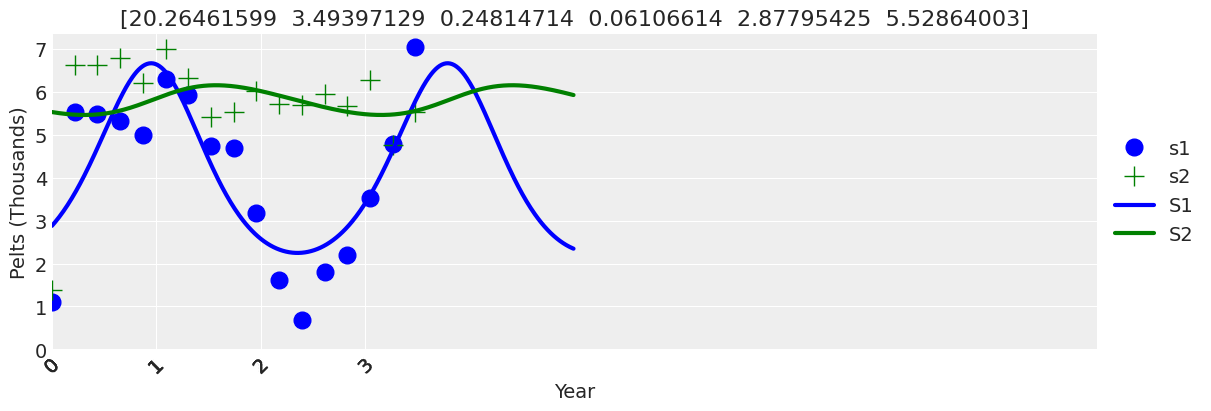

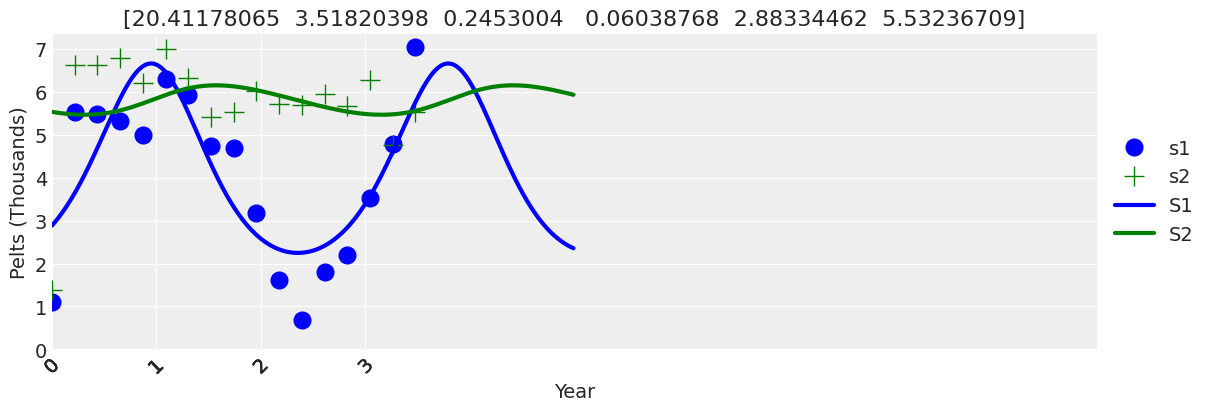

In [ ]:
pytensor.config.floatX = 'float64'
pd.set_option('display.precision', 10)
az.style.use("arviz-darkgrid")
rng = np.random.default_rng(1234)
time = np.arange(0, 5, 0.01)

# data = pd.DataFrame(dict(
#     year = np.arange(1900., 1921., 1),
#     lynx = np.array([4.0, 6.1, 9.8, 35.2, 59.4, 41.7, 19.0, 13.0, 8.3, 9.1, 7.4,
#                 8.0, 12.3, 19.5, 45.7, 51.1, 29.7, 15.8, 9.7, 10.1, 8.6]),
#     hare = np.array([30.0, 47.2, 70.2, 77.4, 36.3, 20.6, 18.1, 21.4, 22.0, 25.4,
#                  27.1, 40.3, 57.0, 76.6, 52.3, 19.5, 11.2, 7.6, 14.6, 16.2, 24.7])))


def plot_data(ax, lw=2, title="Hudson's Bay Company Data"):
    ax.plot(data.year, data.iloc[:, 0], color="b", lw=lw, marker="o", markersize=12, label="s1")
    ax.plot(data.year, data.iloc[:, 1], color="g", lw=lw, marker="+", markersize=14, label="s2")
    ax.legend(fontsize=14, loc="center left", bbox_to_anchor=(1, 0.5))
    ax.set_xlim([0, 10])
    ax.set_ylim(0)
    ax.set_xlabel("Year", fontsize=14)
    ax.set_ylabel("Pelts (Thousands)", fontsize=14)
    ax.set_xticks(data.year.astype(int))
    ax.set_xticklabels(ax.get_xticks(), rotation=45)
    ax.set_title(title, fontsize=16)
    return ax

_, ax = plt.subplots(figsize=(12, 4))
plot_data(ax);

@njit
def lotka_volterra(X, t, theta):
    x, y = X
    alpha, beta, gamma, delta, xt0, yt0 = theta
    dx_dt = alpha * x - beta * x * y
    dy_dt = -gamma * y + delta * x * y
    return [dx_dt, dy_dt]

def plot_model(
    ax,
    x_y,
    time=time,
    alpha=1,
    lw=3,
    title="Lotka-Volterra Model",
):
    ax.plot(time, x_y[:, 0], color="b", alpha=alpha, lw=lw, label="S1")
    ax.plot(time, x_y[:, 1], color="g", alpha=alpha, lw=lw, label="S2")
    ax.legend(fontsize=14, loc="center left", bbox_to_anchor=(1, 0.5))
    ax.set_title(title, fontsize=16)
    return ax

for i in range(10):
    theta = np.array([0.85, 0.012, 3.36, 0.0175, 223, 1.12])
    theta = np.array([random.random()]*6)
    theta[1] = random.random()/100
    theta[3] = random.random()/100
    theta[4] = random.random()*100
    theta[5] = random.random()*100


    def ode_model_resid(theta):
        return (
            data.iloc[:, [0, 1]] - odeint(func=lotka_volterra, y0=theta[-2:], t=data.year, args=(theta,))
        ).values.flatten()
    lower_bound = [0] * len(theta)
    upper_bound = [np.inf] * len(theta)
    results = least_squares(ode_model_resid, x0=theta, bounds = (lower_bound, upper_bound))

    theta = results.x
    # print(theta)
    x_y = odeint(func=lotka_volterra, y0=theta[-2:], t=time, args=(theta,))
    fig, ax = plt.subplots(figsize=(12, 4))
    plot_data(ax, lw=0)
    plot_model(ax, x_y, title=str(theta));


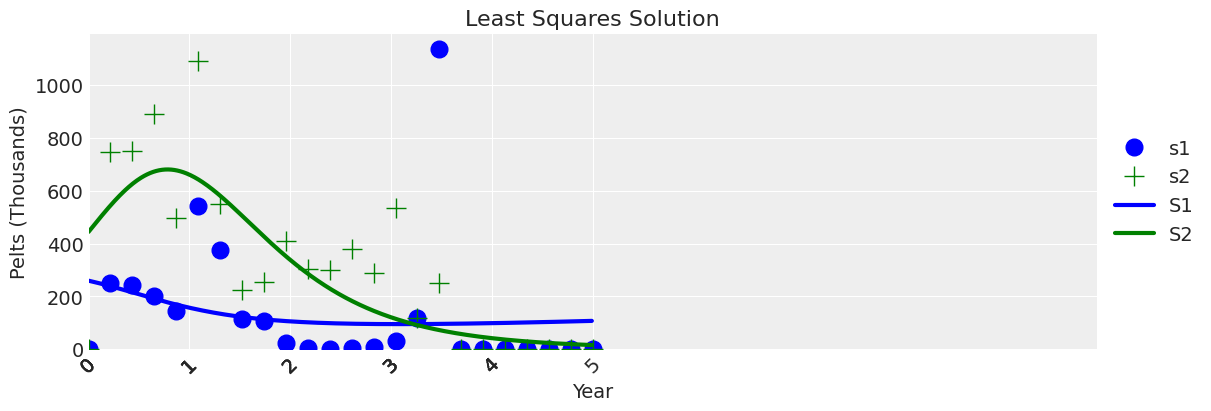

In [ ]:
def get_mean(param):
  return az.summary(trace).loc[param]['mean']
theta = [get_mean('alpha'), get_mean('beta'), get_mean('gamma'), get_mean('delta'), get_mean('xto'), get_mean('yto')]
x_y = odeint(func=lotka_volterra, y0= theta[-2:], t=time, args=(theta,))
f, ax = plt.subplots(figsize=(12, 4))
plot_data(ax, lw=0)
plot_model(ax, x_y, title="Least Squares Solution");

In [ ]:
theta

[1.072, 0.032, 0.573, 0.047, 23.371, 0.001]

In [ ]:
[get_mean('alpha'), get_mean('beta'), get_mean('gamma'), get_mean('delta')]

[1.052, 0.045, 0.537, 0.066]

In [ ]:
[get_mean('xto'), get_mean('yto')]

[23.689, 0.0]

In [ ]:
model.debug()

point={'X_0_interval__': array(0.), 'r_0_interval__': array(-3.91202301), 'K_0_interval__': array(6.90775528), 'X_1_interval__': array(0.), 'r_1_interval__': array(-3.91202301), 'K_1_interval__': array(6.68461173), 'X_2_interval__': array(0.), 'r_2_interval__': array(-4.60517019), 'K_2_interval__': array(5.29831737), 'X_3_interval__': array(0.), 'r_3_interval__': array(-4.60517019), 'K_3_interval__': array(0.), 'X_4_interval__': array(0.), 'r_4_interval__': array(-4.60517019), 'K_4_interval__': array(0.), 'X_5_interval__': array(6.2146081), 'r_5_interval__': array(-0.91629073), 'K_5_interval__': array(7.31322039), 'alpha_0_0_interval__': array(0.), 'alpha_0_1_interval__': array(-4.60517019), 'alpha_0_2_interval__': array(-4.60517019), 'alpha_0_3_interval__': array(-4.60517019), 'alpha_0_4_interval__': array(-4.60517019), 'alpha_0_5_interval__': array(-4.60517019), 'alpha_1_0_interval__': array(-3.91202301), 'alpha_1_1_interval__': array(0.), 'alpha_1_2_interval__': array(-4.60517019), 

In [ ]:
r + alpha + K

[0.02, 0.01, 1, 0.01, 0.02, 1, 5000, 800]

In [ ]:
import pymc as pm
import pytensor.tensor as pt

# Define some dummy PyMC variables
with pm.Model() as model:
  a = pm.Normal("a", mu=0, sigma=1)
  b = pm.Normal("b", mu=1, sigma=1)
  c = pm.Normal("c", mu=2, sigma=1)

# Stack the variables into a single tensor
  stacked_tensor = pm.math.stack([a, b, c])

  print(stacked_tensor)

MakeVector{dtype='float64'}.0


In [ ]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from lmfit import minimize, Parameters

def lotka_volterra(t, y, a, b, c, d):
    x, y = y
    dxdt = a * x - b * x * y
    dydt = -c * y + d * x * y
    return [dxdt, dydt]

def generate_data(params, t):
    sol = solve_ivp(lotka_volterra, [t[0], t[-1]], [90, 1], args=(params['a'], params['b'], params['c'], params['d']), t_eval=t)
    return sol.y.T

def objective(params, t, data):
    model = generate_data(params, t)
    return (model - data).ravel()

t = np.linspace(0,2, 20)

data = np.array(pd.DataFrame({species_list[i] : table.iloc[pos] for i, pos in enumerate([0, 3])}))

params = Parameters()
params.add('a', value=7, min=0, max=7)
params.add('b', value=0.01, min=0, max=5)
params.add('c', value=0.6, min=0, max=5)
params.add('d', value=0.005, min=0, max=5)

result = minimize(objective, params, args=(t, data))

for name, param in result.params.items():
    print(f'{name}: {param.value:.4f}')

a = result.params['a'].value
b = result.params['b'].value
c = result.params['c'].value
d = result.params['d'].value


plt.figure(figsize=(10, 5))
plt.plot(t, data[:, 0], 'b.', label='T Data')
plt.plot(t, data[:, 1], 'r.', label='Epi Data')

fitted_data = generate_data(result.params, t)
plt.plot(t, fitted_data[:, 0], 'b-', label='Fitted Prey')
plt.plot(t, fitted_data[:, 1], 'r-', label='Fitted Predator')

plt.legend()
plt.xlabel('Time')
plt.ylabel('Population')
plt.show()


In [ ]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

def predator_prey(y, t, alpha, beta, gamma, delta):
    x, y = y
    dxdt = alpha*x - beta*x*y
    dydt = delta*x*y - gamma*y
    return [dxdt, dydt]

x0 = 90.
y0 = 1.

t = np.linspace(0,10, 1000)

sol = odeint(predator_prey, [x0, y0], t, args=(a,b,c,d))
prey = sol[:, 0]
predators = sol[:, 1]

plt.figure(figsize=(10, 6))
plt.plot(t, prey, label='T')
plt.plot(t, predators, label='Epi')
plt.title('Lotka-Volterra Predator-Prey Model')
plt.xlabel('Time')
plt.ylabel('Population')
plt.legend()
plt.grid(True)
plt.show()


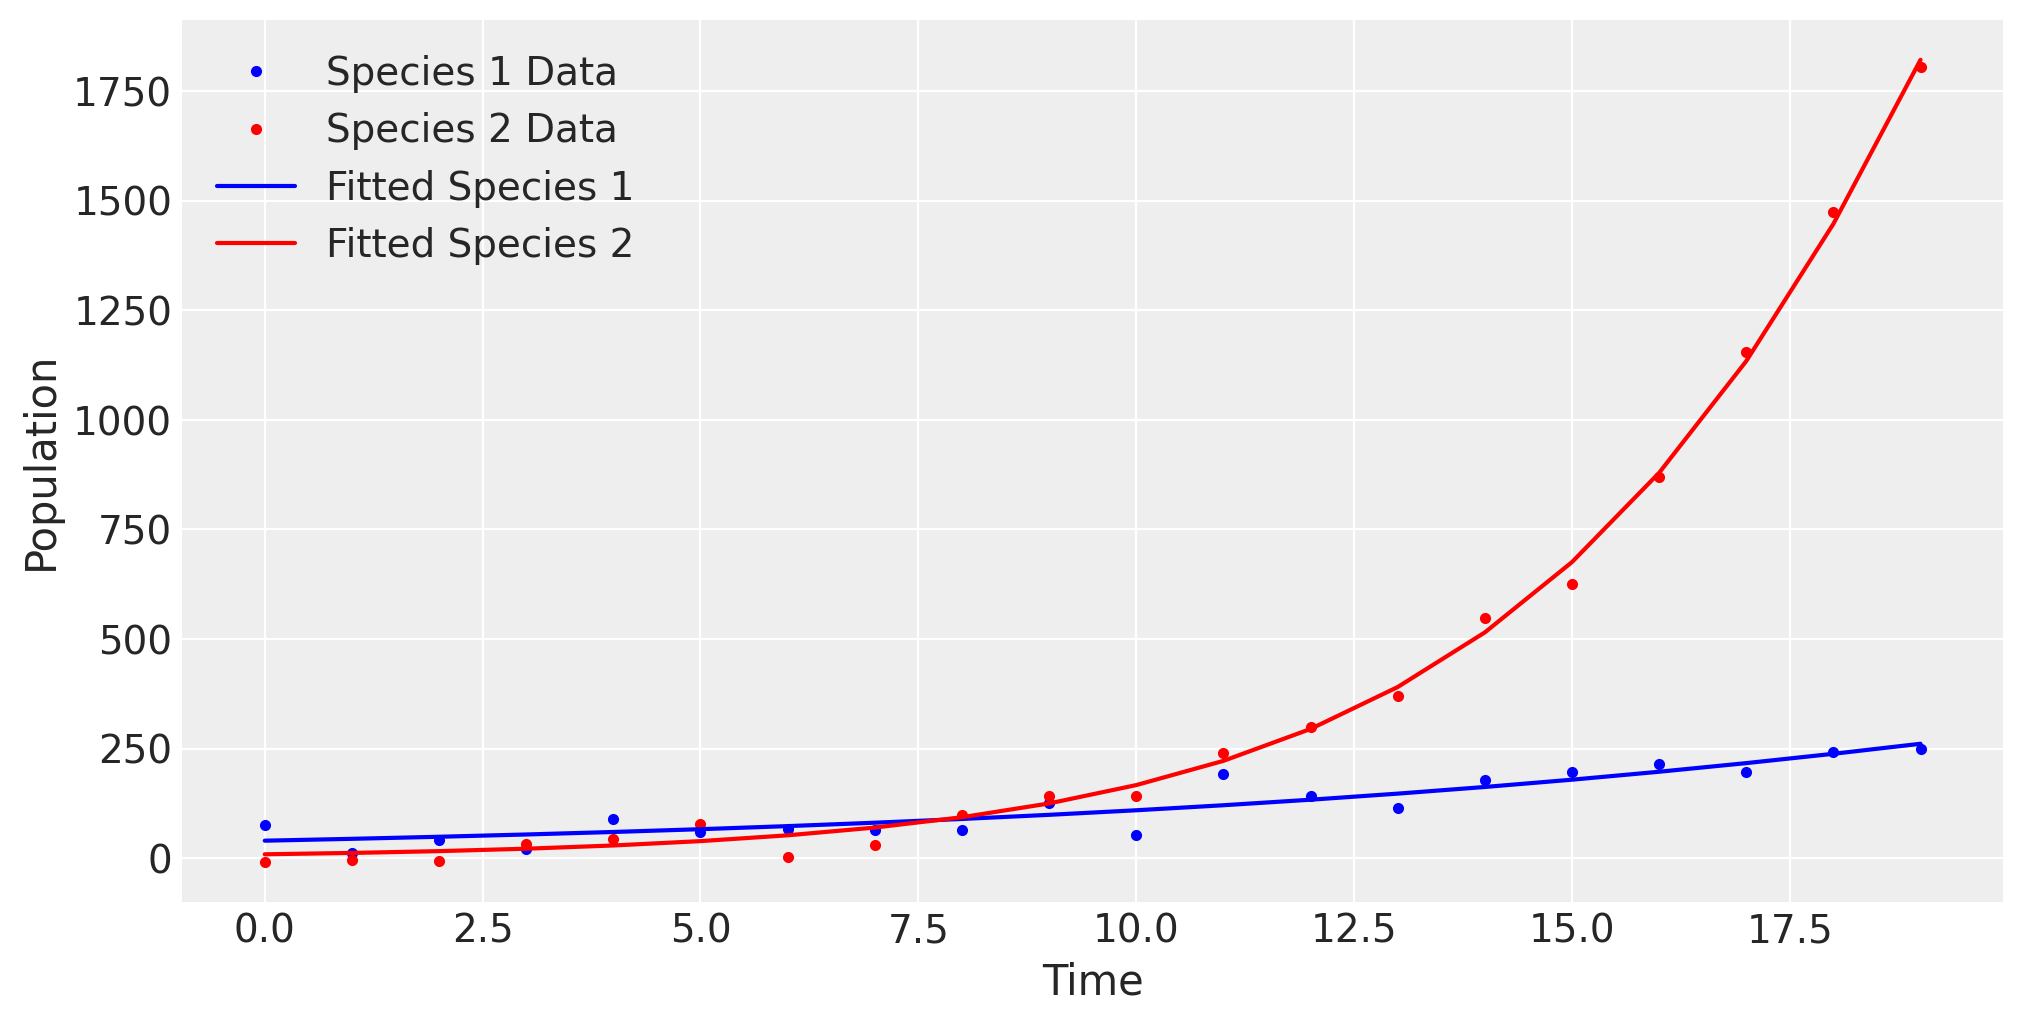

In [ ]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from lmfit import minimize, Parameters
import pandas as pd

def lotka_volterra_multi(t, X, r, alpha, K, species_list):
    dXdt = []
    for i, species_i in enumerate(species_list):
        growth = r[species_i] * X[i] * (1 - ((X[i] + (sum((alpha[species_i][species_j] * X[j]) for j, species_j in enumerate(species_list) if i != j))) / K[species_i]))
        dXdt.append(growth)
    return dXdt

def generate_alpha_dict(params, species_list):
    alpha = {}
    for i, species_i in enumerate(species_list):
        alpha[species_i] = {}
        for j, species_j in enumerate(species_list):
            if i != j:
                alpha_value = params[f'alpha_{species_i}_{species_j}'].value
                alpha[species_i][species_j] = alpha_value
    return alpha

def generate_data_multi(params, t, species_list):
    r = {species: params[f'r_{species}'].value for species in species_list}
    K = {species: params[f'K_{species}'].value for species in species_list}

    alpha = generate_alpha_dict(params, species_list)
    #change
    initial_conditions = [40, 9]
    sol = solve_ivp(lotka_volterra_multi, [t[0], t[-1]], initial_conditions,
                    args=(r, alpha, K, species_list), t_eval=t)
    return sol.y.T

def generate_synthetic_data(params, t, species_list, noise_level=30):
    r = {species: params[f'r_{species}'].value for species in species_list}
    K = {species: params[f'K_{species}'].value for species in species_list}

    alpha = generate_alpha_dict(params, species_list)
    #change
    initial_conditions = [40, 9]
    sol = solve_ivp(lotka_volterra_multi, [t[0], t[-1]], initial_conditions,
                    args=(r, alpha, K, species_list), t_eval=t)
    data = sol.y.T + noise_level * np.random.normal(size=sol.y.T.shape)
    return data

def objective_multi(params, t, data, species_list):
    model = generate_data_multi(params, t, species_list)
    return (model - data).ravel()

def initialize_params(species_list, growths, capacities, affectings):
    params = Parameters()

    for i, species in enumerate(species_list):
        params.add(f'r_{species}', value=growths[i], min=0, max=5)
        params.add(f'K_{species}', value=capacities[i], min=0, max=20000)

    count = 0
    for i, species_i in enumerate(species_list):
        for j, species_j in enumerate(species_list):
            if i != j:
                params.add(f'alpha_{species_i}_{species_j}', value=affectings[count], min=0, max=1)
                count += 1
    return params

#change
t = np.linspace(0, 19, 20)
species_list = ['s1', 's2']
# species_list = np.array(table.index[[0, 3]])
params = initialize_params(species_list, [0.2, 0.2], [8000, 5000], [0.02, 0.01])
data = generate_synthetic_data(initialize_params(species_list, [0.1, 0.3], [8000, 5000], [0.02, 0.01]), t, species_list)
# np.array(pd.DataFrame({species_list[i] : table.iloc[pos] for i, pos in enumerate([0, 3])}))

#change


result = minimize(objective_multi, params, args=(t, data, species_list))

r_optimized = {species: result.params[f'r_{species}'].value for species in species_list}
K_optimized = {species: result.params[f'K_{species}'].value for species in species_list}
alpha_optimized = generate_alpha_dict(result.params, species_list)

plt.figure(figsize=(10, 5))
plt.plot(t, data[:, 0], 'b.', label='Species 1 Data')
plt.plot(t, data[:, 1], 'r.', label='Species 2 Data')

fitted_data = generate_data_multi(result.params, t, species_list)
plt.plot(t, fitted_data[:, 0], 'b-', label='Fitted Species 1')
plt.plot(t, fitted_data[:, 1], 'r-', label='Fitted Species 2')

plt.legend()
plt.xlabel('Time')
plt.ylabel('Population')
plt.show()


In [ ]:
alpha_optimized

In [ ]:
r_optimized

In [ ]:
K_optimized

In [ ]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

# Define the Lotka-Volterra equations for multiple species
def lotka_volterra_multi(X, t, r, alpha, K, species_list):
    dXdt = []
    for i, species_i in enumerate(species_list):
        growth = r[species_i] * X[i] * (1 - ((X[i] + (sum((alpha[species_i][species_j] * X[j]) for j, species_j in enumerate(species_list) if i != j))) / K[species_i]))
        dXdt.append(growth)
    return dXdt

# Initial populations
X0 = [90, 0]

# Time points
t = np.linspace(0, 200, 1000)

# Solve ODE
result = odeint(lotka_volterra_multi, X0, t, args=(r_optimized, alpha_optimized, K_optimized, species_list))

# Convert result back to a dictionary
result_dict = {species: result[:, i] for i, species in enumerate(species_list)}

# Plot results
plt.figure(figsize=(10, 6))
for species, population in result_dict.items():
    plt.plot(t, population, label=species)
plt.xlabel('Time')
plt.ylabel('Population')
plt.legend()
plt.title('Lotka-Volterra Simulation of Cell Competition')
plt.show()


In [ ]:
r_optimized

In [ ]:
alpha_optimized

In [ ]:
K_optimized

In [ ]:
def lotka_volterra_multi(t, X, r, alpha, K, species_list):
    dXdt = []
    for i, species_i in enumerate(species_list):
        growth = r[species_i] * X[i] * (1 - sum(alpha[species_i][species_j] * X[j] / K[species_i] for j, species_j in enumerate(species_list) if i != j))
        dXdt.append(growth)
    return dXdt
X0 = lotka_volterra_multi(t, X0, r_optimized, alpha_optimized, K_optimized, species_list)
lotka_volterra_multi(t, X0, r_optimized, alpha_optimized, K_optimized, species_list)

In [ ]:
sc.tl.umap(adata1, n_components=3)

In [ ]:
color = dict(zip(range(15), plt.cm.tab20(range(15))))

In [ ]:
umap = adata1.obsm['X_umap']
umap

In [ ]:
!mkdir figs

In [ ]:
for i in[30, 60, 120, 150, 210, 240]:
  fig = plt.figure(figsize = (10,10))
  ax = fig.add_subplot(projection = '3d')
  ax.scatter(umap[:,0], umap[:,1], umap[:,2], c = adata1.obs.leiden.astype('int').map(color))
  x_center = (umap[:,0].max() + umap[:,0].min())/2
  y_center = (umap[:,1].max() + umap[:,1].min())/2
  z_center = (umap[:,2].max() + umap[:,2].min())/2

  ax.plot([x_center,x_center], [y_center, y_center], [umap[:,2].min() - 2, umap[:,2].max() + 2], c = 'k', lw = 5)
  ax.plot([x_center,x_center], [umap[:,1].min() - 2, umap[:,1].max() + 2], [z_center, z_center], c = 'k', lw = 5)
  ax.plot([umap[:,0].min() - 2, umap[:,0].max() + 2], [y_center, y_center], [z_center, z_center], c = 'k', lw = 5)
  ax.view_init (20, i)
  ax.axis('off')
  plt.savefig(f'figs/{i:003}.png', dpi = 100, facecolor = 'white')
  plt.show()

In [ ]:
!